####  

- Update future: pip install -U future

- Download the data:
- https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
- Download the word vectors:
- http://nlp.stanford.edu/data/glove.6B.zip
   or
- https://drive.google.com/uc?id=1WJjHzuxJwiioEB8hluWcYC0SnjiZN-1v&export=download

In [2]:
from __future__ import print_function, division
from builtins import range

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input,Embedding
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

#### Configuration

In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

#### Load in pre-trained word vectors

- Raw data is in txt format, each row start with word and follow by vector
- Convert to dictionary

In [4]:
word2vec = {}

with open(os.path.join('large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding = 'utf8') as f:
     # is just a space-separated text file in the format:
     # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype = 'float32')
        word2vec[word] = vec
print('Found %s word vectors.' %len(word2vec))

Found 400000 word vectors.


#### Prepare text samples and their labels

- Target shape -- N*6
- N is the samples
- 6 is possible label

In [5]:
train = pd.read_csv('large_files/toxic-comment/train.csv')
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

#### Convert the sentences into integers

In [6]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

#### Get word >> integer mapping

In [7]:
word2idx = tokenizer.word_index
print("Found %s unique tokens."% len(word2idx))

Found 210337 unique tokens.


#### Pad sequences so that we get a N*T matrix

- N: Samples
- T: Length

In [8]:
data = pad_sequences(sequences,maxlen = MAX_SEQUENCE_LENGTH)
print("shape of data tensor:", data.shape)

shape of data tensor: (159571, 100)


#### Prepare embedding matrix

- In Keras word tokenizer, 0 is for unknown, real word start from 1
- use get function, if word not exist in dict, return None

- embedding -- V * D
- V: Vocabulary size 
- D: Dimension

In [9]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx.items():
    if i <MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
            

Filling pre-trained embeddings...


#### load pre-trained word embeddings into an Embedding layer
#### note that we set trainable = False so as to keep the embeddings fixed

In [10]:
embedding_layer = Embedding(
num_words, EMBEDDING_DIM,
weights = [embedding_matrix],
input_length = MAX_SEQUENCE_LENGTH,
trainable = False)

###### Global Max Pool
- have a time series and we don't care how long it is, just take the max value in the time series in each dimension
- T * M --> Global max pool --> M
- choosing whick point in time was the most important for computing

#### train a LSTM Model 

- Can be LSTM or BiLSTM
- BiLSTM works a little better

In [19]:
input_ = Input(shape = (MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
##x =LSTM(15,return_sequences = True)(x) 
x = Bidirectional(LSTM(15,return_sequences = True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels),activation = 'sigmoid')(x)

model = Model(input_,output)
model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(lr = 0.01),
             metrics=['accuracy'])

print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT,
  verbose = 1
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 482s 4ms/step - loss: 0.0696 - acc: 0.9768 - val_loss: 0.0564 - val_acc: 0.9800
Epoch 2/5
127656/127656 [==============================] - 477s 4ms/step - loss: 0.0537 - acc: 0.9810 - val_loss: 0.0527 - val_acc: 0.9811
Epoch 3/5
127656/127656 [==============================] - 477s 4ms/step - loss: 0.0511 - acc: 0.9817 - val_loss: 0.0532 - val_acc: 0.9811
Epoch 4/5
127656/127656 [==============================] - 476s 4ms/step - loss: 0.0499 - acc: 0.9819 - val_loss: 0.0533 - val_acc: 0.9811
Epoch 5/5
127656/127656 [==============================] - 477s 4ms/step - loss: 0.0488 - acc: 0.9822 - val_loss: 0.0520 - val_acc: 0.9813


#### Plot some data

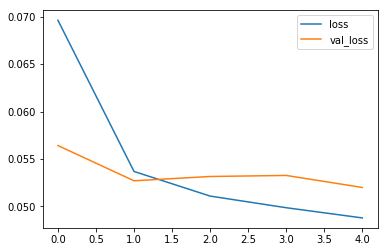

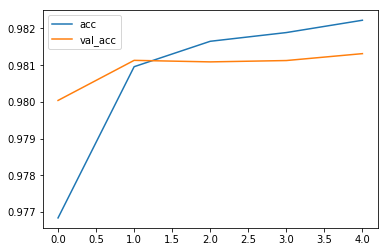

In [27]:
plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'],label = 'acc')
plt.plot(r.history['val_acc'],label = 'val_acc')
plt.legend()
plt.show()

p = model.predict(data)
aucs = []




In [28]:
for j in range(6):
    auc = roc_auc_score(targets[:,j],p[:,j])
    aucs.append(auc)
    
print(np.mean(aucs))


0.980518628310013
